In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
from datetime import date, timedelta
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import time

#### Figure aesthetics

In [2]:
#print(plt.style.available)
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

#### Prepare dataset

In [3]:
## prepare dataset

def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"        
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

get_data()

confirmed = pd.read_csv("confirmed_man_cor.csv")
deaths = pd.read_csv("deaths_man_cor.csv")
recovered = pd.read_csv("recovered_man_cor.csv")

#confirmed = pd.read_csv("confirmed.csv")
#deaths = pd.read_csv("deaths.csv")
#recovered = pd.read_csv("recovered.csv")



def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    #data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

#recovered = recovered.loc["Poland"]


In [4]:
#inactive=deaths.add(recovered)
#data=confirmed.subtract(inactive)

##romeve for blog
#data=confirmed 

#data=data.transpose().reset_index().rename(columns={'index':'Date'})
#data['Date'] = pd.to_datetime(data['Date'])

inactive=deaths.add(recovered)
#data=confirmed.subtract(inactive)
data = confirmed
data_in = inactive

data=data.transpose().reset_index().rename(columns={'index':'Date'})
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

data_in=data_in.transpose().reset_index().rename(columns={'index':'Date'})
data_in['Date'] = pd.to_datetime(data_in['Date'], errors='coerce')

#### List of countries in dataset

In [5]:
for el in data.columns:
    print(el)

Date
Poland


#### Get populations for countries in dataset

In [6]:
#data from: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population 
#Was manually saved to csv. 
population_df=pd.read_csv("countries_population.csv",  encoding = "ISO-8859-1", header=None, usecols=[1,2], names=["country_name", "population"])
population_df

population_df['population'] = population_df['population'].apply(lambda x: str(x).replace(",", ""))
population_df['population'] = pd.to_numeric(population_df['population'], errors="coerce")

In [7]:
dictionary_country_names={
"US":"United States",
"Congo (Kinshasa)":"Congo",
"Cote d'Ivoire":"Ivory Coast",
"Czechia":"Czech Republic",
"French Guiana":"Guyana",
"Korea, South":"South Korea",
}

countries_populations = {}

for data_country_name in data.columns[1:]:
    searchfor=[data_country_name]
    try:
        searchfor.append(dictionary_country_names[data_country_name])
    except:
        pass
    
    check_names=0
    if check_names==1:
        if len(population_df[population_df["country_name"].str.contains('|'.join(searchfor))]) != 1:
            print(" ")   
            print(data_country_name)
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))] )
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum() )
            print(" ")
    countries_populations[data_country_name]=population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum()

#### Choose country to plot 

In [8]:
country_to_plot="Poland"
considered_countries={"predict":country_to_plot,}

In [9]:
fit_variants={
#"epidemia zacznie zwalniać po 2 dniach":2.0,
#"spowolnienie +6 dni od 25.03":6.0,
#"spowolnienie +12 dni od 25.03":12.0,
}

In [10]:
data = data.dropna()
data_in = data_in.dropna()

#### Dates to num

In [11]:
##extract data for each country, divide by population and multiply by the value of per_num
dates=data["Date"].values
#print(dates)
dates_num_org = mdates.date2num(dates)
dates_start = np.min(dates_num_org)
dates_num = dates_num_org - dates_start

date_epidemic_threat = datetime.date(2020, 3, 13)
#date_shutdown is a date from which days to inflection point of sigmoids are calculated
date_shutdown = datetime.date(2020, 3, 25)
end_hist_exp = int(mdates.date2num(date_shutdown)-dates_start)
#print(end_hist_exp)
#print(mdates.num2date(end_hist_exp+dates_start))

#start of linear
date_linear_start = datetime.date(2020, 7, 27)
linear_start = int(mdates.date2num(date_linear_start)-dates_start)
print(linear_start)
#print(mdates.num2date(linear_start+dates_start))


yesterday = date.today() - timedelta(days=1)
end_exp_yesterday = int(mdates.date2num(yesterday)-dates_start)

#value for blog
last_day_to_extrapolate = datetime.date(2020, 9, 30)

today=mdates.date2num(date.today())
days_to_extrapolate = mdates.date2num(last_day_to_extrapolate)
days_to_extrapolate=days_to_extrapolate-today

187


#### Fit
Fits are performed on data normalized by country population. 

Currently as number of cases per 100 000 people.

Later for plotting data is "uunormalized"

In [12]:
#num days to extrapolate

dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

#for d1, d2 in zip(dates_num[:51], dates_num_extrapolate[:51]):
#    print(d1, d2)

#num iterations
maxit=100000
#for normalization
per_num=100000

def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

def sigmoid(x, L , k, b, x0):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

def linear(x, a, b):
    y = a*x+b
    return y

#for tests
#def generalised_sigmoid(x, L , k, b, x0, dummy):
#    y = L / (1 + np.exp(-k*(x-x0)))+b
#    return y

def sub_exponent(x, r, p, A):
#   y = (r*(1-p)*(x-x0) + A)**(1/(1-p))
    y = (r*(1-p)*x + A)**(1/(1-p))
    return y

def generalised_sigmoid(x, K, C, B, mi, x0):
    y = K / (C + np.exp(-B*(x-x0)))**(1/mi)
    #penalization = abs(1.0 - C)*1000000
    #penalization2 = abs(2 - (C + np.exp(-B*(77-x0)))**(1/mi))*100
    #return y + penalization + penalization2
    return y

#fit free exponent to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
pred_exp_popt, pred_exp_pcov = curve_fit(exponent, dates_num, pred_data, maxfev=maxit)
print(pred_exp_popt)
pred_exp_fit = exponent(dates_num_extrapolate, *pred_exp_popt)


#fit sub exponent to the data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
skip_initial_days=int(8)
(subexp_start)=np.min(np.nonzero(pred_data))+skip_initial_days
subexp_pred_data = pred_data[subexp_start:]
subexp_dates_num=dates_num[subexp_start:]
#subexp_dates_num_extrapolate=dates_num_extrapolate[subexp_start:]
subexp_dates_num_extrapolate=dates_num_extrapolate[0:]

sub_exp_popt, sub_exp_pcov = curve_fit(sub_exponent, subexp_dates_num, subexp_pred_data, 
                                       maxfev=maxit*10000, 
                                       p0=[0.3,0.9,5.0],
                                        #method="dogbox",
                                      )
sub_exp_fit=sub_exponent(subexp_dates_num_extrapolate, *sub_exp_popt)
sub_exp_fit = np.nan_to_num(sub_exp_fit, nan=0.0)
#print(sub_exp_fit)

print("sub exponent")
print(sub_exp_popt)


##fit unfixed sigmoid to data
pred_sig_popt, pred_sig_pcov = curve_fit(sigmoid, dates_num, pred_data, p0=[np.max(pred_data),1,1,1], maxfev=maxit)
print("unfixed sigmoid")
print(pred_sig_popt)
pred_sig_fit = sigmoid(dates_num_extrapolate, *pred_sig_popt)

##fit sigmoid with given x for half value to data
pred_sig_popt_fixed={}
pred_sig_pcov_fixed={}
pred_sig_fit_fixed={}

for variant_name, variant_value in zip(fit_variants, fit_variants.values()):
    print(variant_name, variant_value)
    
    x0 = int((mdates.date2num(date_shutdown)-dates_start) + variant_value)
    print (x0)
    fixed_sigmoid = lambda x, L , k, b: sigmoid(x, L , k, b, x0)

    pred_sig_popt_fixed[variant_name], pred_sig_pcov_fixed[variant_name] = curve_fit(fixed_sigmoid , dates_num[:x0+1], pred_data[:x0+1], p0=pred_sig_popt[:-1])
    pred_sig_fit_fixed[variant_name] = fixed_sigmoid(dates_num_extrapolate, *pred_sig_popt_fixed[variant_name])
    
    print(pred_sig_popt_fixed[variant_name])
    

##fit unfixed general sigmoid to data
gen_sig_popt, gen_sig_pcov = curve_fit(generalised_sigmoid, dates_num, pred_data, maxfev=maxit*1000)

unnorm=countries_populations[considered_countries["predict"]]/per_num
print("Unfixed genera sigmoid")
print(gen_sig_popt)
print(gen_sig_popt*unnorm)
gen_sig_fit = generalised_sigmoid(dates_num_extrapolate, *gen_sig_popt)


gen_sig_popt_fixed={}
gen_sig_pcov_fixed={}
gen_sig_fit_fixed={}

##fit linear to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
linear_pred_data = pred_data[linear_start:]
linear_dates_num=dates_num[linear_start:]
linear_dates_num_extrapolate=dates_num_extrapolate[0:]

linear_popt, linear_pcov = curve_fit(linear, linear_dates_num, linear_pred_data, 
                                       maxfev=maxit*10000, 
                                        #method="dogbox",
                                      )
linear_fit=linear(linear_dates_num_extrapolate, *linear_popt)
print("linear:")
print(linear_popt*unnorm)
lin_perr = np.sqrt(np.diag(linear_pcov))*unnorm
print(lin_perr)


##
##fit linear to inactive data
date_linear_in_start = datetime.date(2020, 4, 29)
linear_start_in = int(mdates.date2num(date_linear_in_start)-dates_start)

#below caused problem assigns inactive to actve for plotting

pred_data_in=(data_in[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
linear_pred_data = pred_data_in[linear_start_in:]
linear_dates_num_in=dates_num[linear_start_in:]
linear_dates_num_in_extrapolate=dates_num_extrapolate[0:]

linear_popt, linear_pcov = curve_fit(linear, linear_dates_num_in, linear_pred_data, 
                                       maxfev=maxit*10000, 
                                        #method="dogbox",
                                     )
linear_fit_in=linear(linear_dates_num_in_extrapolate, *linear_popt)
print("linear inactive:")
print(linear_popt*unnorm)



[1.80520255e+01 1.52685474e-02 6.24695348e+01]
sub exponent
[  0.46435556   0.16331098 -19.4260592 ]
unfixed sigmoid
[ 1.55725372e+02  2.78107862e-02 -7.97297641e+00  1.38905849e+02]


/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in power


Unfixed genera sigmoid
[ 2.36727945e-58  9.54021640e-01  1.69182250e-02  3.41526852e-04
 -3.43851187e+02]
[ 9.08703891e-56  3.66210747e+02  6.49422983e+00  1.31098497e-01
 -1.31990717e+05]
linear:
[   653.31071429 -79055.94523827]
[  10.10543733 1960.94095626]
linear inactive:
[   359.6950176  -33919.82820876]


In [13]:
#Prediction for long term
#Inactive, active etc

def normal_distribution(x, maximum, sigma, mu):
#    mu=103
    pi=3.14159
    y = (maximum / (sigma*np.sqrt(2*pi)))* np.exp(-0.5*(((x-mu)/sigma)**2))
    return y


def generalised_sigmoid_fixed(x, K, B, mi, x0):
    C=1.0
    y = K / (C + np.exp(-B*(x-x0)))**(1/mi)
    return y

# extract data for each country, divide by population and multiply by the value of per_num
dates=data["Date"].values
dates_num = mdates.date2num(dates)
dates_start = np.min(dates_num)
dates_num = dates_num - dates_start

#days_to_extrapolate=60
#dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

print(dates_num)
countries=[]
fits=[]
sig_fits=[]

fits_in=[]
sig_fits_in=[]
countries_in=[]

fixed_sig_fits_in = []
normal_fits_act = []
normal_fits_act_fixed = []

L = 210000
per_num=100000

countries_to_plot=["Poland"]

for country in countries_to_plot:
    countries.append((data[country].values))
    #fit total
    popt, pcov = curve_fit(exponent, dates_num, (data[country].values), maxfev=10000)

    fixed_sigmoid = lambda x, k, b, x0: sigmoid(x, L , k, b, x0)
    #sig_popt, sig_pcov = curve_fit(fixed_sigmoid, dates_num, (data[country].values),p0=[1,1,15],maxfev=10000)
    sig_popt, sig_pcov = curve_fit(generalised_sigmoid, dates_num, (data[country].values), p0=[1,1,1,1,1], maxfev=1000000)
 
    fits.append(exponent(dates_num_extrapolate, *popt))
#    sig_fits.append(fixed_sigmoid(dates_num_extrapolate, *sig_popt))
    sig_fits.append(generalised_sigmoid(dates_num_extrapolate, *sig_popt))
    
#    sig_fits.append(sigmoid(dates_num_extrapolate, *sig_popt))
    
    countries_in.append((data_in[country].values))
    #fit inactive

    print(data_in[country].values)

    popt, pcov = curve_fit(exponent, dates_num, (data_in[country].values), maxfev=10000)
    sig_in_popt, sig_in_pcov = curve_fit(sigmoid, dates_num, (data_in[country].values),p0=[np.max(data[country].values),1,1,1],maxfev=10000)
    fits_in.append(exponent(dates_num_extrapolate, *popt))
    sig_fits_in.append(sigmoid(dates_num_extrapolate, *sig_in_popt))
    
    #fit to inactive sigmoid with top value equal to already known sigmoid of active
    L = np.max(generalised_sigmoid(dates_num_extrapolate, *sig_popt))
    #fixed_sigmoid = lambda x, k, b, x0: sigmoid(x, L , k, b, x0)
    #fixed_sig_popt, fixed_sig_pcov = curve_fit(fixed_sigmoid, dates_num, (data_in[country].values),p0=[1,1,25],maxfev=10000)    

    #use general sigmoid
    K=L
    fixed_sigmoid = lambda x, B, mi, x0: generalised_sigmoid_fixed(x, K, B, mi, x0)
    fixed_sig_popt, fixed_sig_pcov = curve_fit(fixed_sigmoid, dates_num, (data_in[country].values), maxfev=10000)    
    fixed_sig_fits_in.append(fixed_sigmoid(dates_num_extrapolate, *fixed_sig_popt))
    
    #temporary generalised sigmoid
    #fixed_sig_popt, fixed_sig_pcov = curve_fit(generalised_sigmoid, dates_num, (data_in[country].values),maxfev=10000)
    #fixed_sig_fits_in.append(generalised_sigmoid(dates_num_extrapolate, *fixed_sig_popt))
    
    
    ##Fiting normal distribution to inactive with given maximum:
    
    normal_popt, normal_pcov = curve_fit(normal_distribution, dates_num, (data[country].values - data_in[country].values), maxfev=100000, p0=[6000,20,40])#p0=[6000,20], 
    normal_fits_act.append(normal_distribution(dates_num_extrapolate, *normal_popt))
    print(normal_popt)
    
    date_max = datetime.date(2020, 5, 3)
    x0 = int((mdates.date2num(date_max)))-dates_start
    mu = x0
    print("mu", mu)
    normal_distribution_fixed = lambda x, maximum, sigma: normal_distribution(x, maximum, sigma, mu)
    normal_popt, normal_pcov = curve_fit(normal_distribution_fixed, dates_num, (data[country].values - data_in[country].values), maxfev=100000, p0=[9000,20])#p0=[6000,20], 
    normal_fits_act_fixed.append(normal_distribution_fixed(dates_num_extrapolate, *normal_popt))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in power
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in power


[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     1     2     3     3    17    18    18     6     6     6
     8     9     9    21    23    23    25    29    38    40    90   113
   127   195   228   269   320   381   458   499   583   671   732   881
   954  1088  1198  1328  1400  1513  1698  1939  2194  2438  2650  2800
  3028  3251  3649  3880  4142  4426  4628  4793  4996  5388  5617  5960
  6222  6498  6643  6970  7271  7579  7825  8090  8376  8564  8851  9145
  9424  9713  9970 10190 10283 11044 11358 11598 11743 12077 12335 12523
 12818 13129 13344 13547 13794 14012 14164 14379 14617 14911 15027 15341
 15473 15639 15926 16207 16633 17032 17527 18039 18435 18948 19530 20066
 20647 21407 21986 22341 22744 23268 23701 24158 24

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


#### Make plots

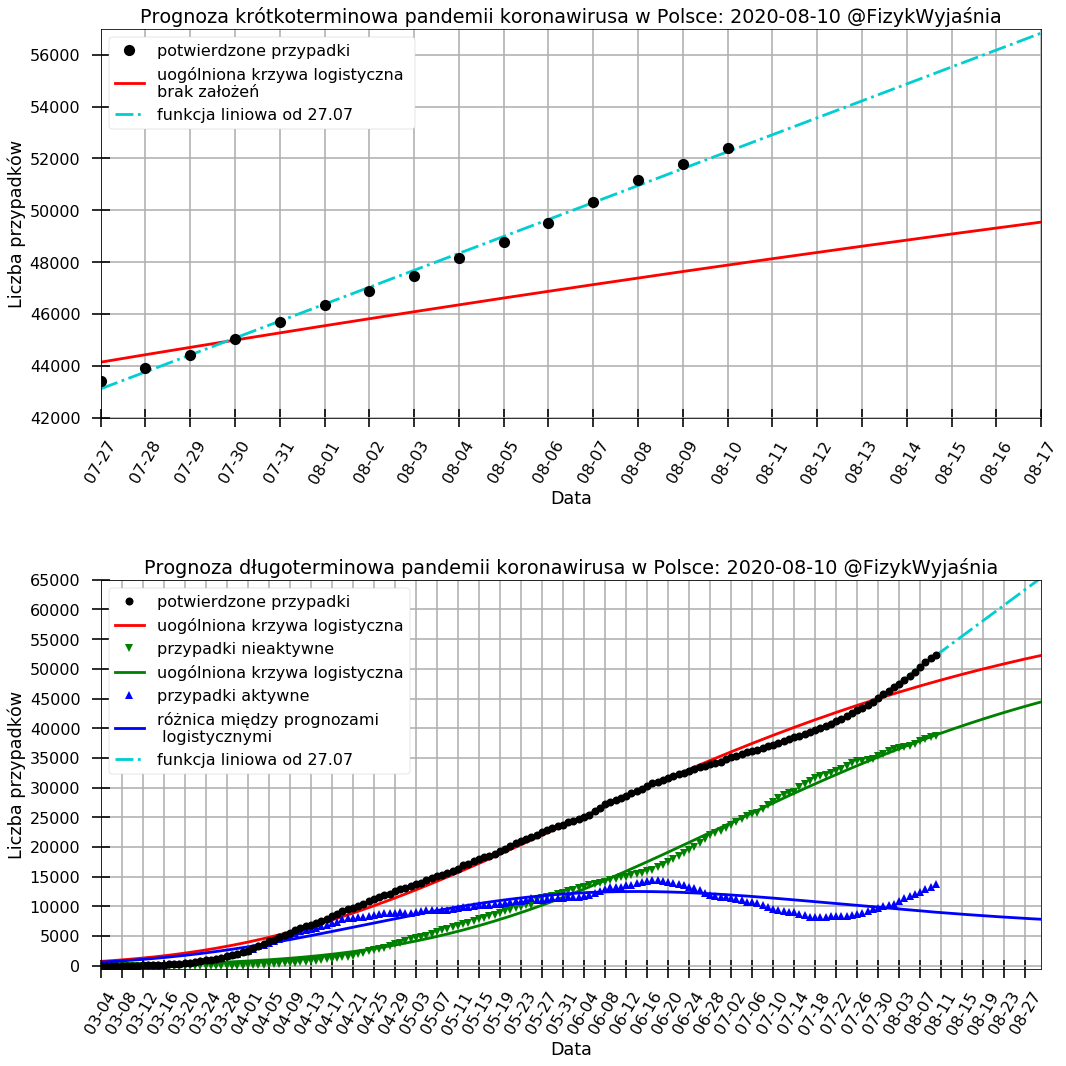

<Figure size 921.6x633.6 with 0 Axes>

In [14]:
## Create figure and plot space
fig, (ax, ax2) = plt.subplots(2,1, figsize=(16, 16), )

marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k','mediumorchid','r', 'darkorange', 'g', 'b', 'y','c','m'))

short_prognosis_title = "Prognoza krótkoterminowa pandemii koronawirusa w Polsce: "+time.strftime("%Y-%m-%d")+" @FizykWyjaśnia"
long_prognosis_title = "Prognoza długoterminowa pandemii koronawirusa w Polsce: "+time.strftime("%Y-%m-%d")+" @FizykWyjaśnia"
x_label = "Data"
y_label = "Liczba przypadków"
date_epidemic_threat_label="stan zagrożenia epidemicznego \n(13.03.2020)"
shutdown_label="zakaz przemieszczania się \n(25.03.2020)"
label_MZ_data="potwierdzone przypadki"
act_lin_label="funkcja liniowa od 27.07"


## Absolute values
unnorm=countries_populations[considered_countries["predict"]]/per_num


## Short term prognosis
col=next(color)
ax.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label=label_MZ_data, color=col, zorder=10)
col=next(color)

col=next(color)
#ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color='darkturquoise', linestyle="dotted", label="aktualny wzrost wykładniczy")
#ax.plot(mdates.num2date(subexp_dates_num_extrapolate+dates_start), sub_exp_fit*unnorm, color='darkturquoise', label="aktualny wzrost sub-wykładniczy", linestyle="-.")
ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), gen_sig_fit*unnorm, color='r', label="uogólniona krzywa logistyczna \nbrak założeń")
ax.plot(mdates.num2date(linear_dates_num_extrapolate[linear_start:]+dates_start), linear_fit[linear_start:]*unnorm, color='darkturquoise', label=act_lin_label, linestyle="-.")


ax.set(xlabel=x_label,
       ylabel=y_label,
       title=short_prognosis_title)

##
#Long term prognosis
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k', 'r', 'g', 'b', 'y','c','darkorange'))

#New type long term prognosis:
for country, country_in, fit, fit_in, fixed_fit, country_name, normal_fit, normal_fit_fixed in zip(countries, countries_in, sig_fits, sig_fits_in, fixed_sig_fits_in, countries_to_plot, normal_fits_act, normal_fits_act_fixed):

    col=next(color)
    ax2.plot(dates, country, marker=next(marker), linestyle='', label=label_MZ_data, color='k', markersize=8, zorder=10)
    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), fit, color='r', label="uogólniona krzywa logistyczna")

#Use only to control subexponent    
#    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="aktualny wzrost wykładniczy", zorder=9)
#    ax2.plot(mdates.num2date(subexp_dates_num_extrapolate+dates_start), sub_exp_fit*unnorm, color="darkturquoise", label="aktualny wzrost sub-wykładniczy", linestyle="-.", zorder=0)
    
    col=next(color)
    ax2.plot(dates, country_in, marker=next(marker), linestyle='', label="przypadki nieaktywne", color='g', markersize=8)
    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), fixed_fit, label="uogólniona krzywa logistyczna", color='g')
    
    col=next(color)
    ax2.plot(dates, country - country_in, marker=next(marker), linestyle='', label="przypadki aktywne", color='b', markersize=8)
    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), fit - fixed_fit, label="różnica między prognozami \n logistycznymi", color='b') 
    
ax2.plot(mdates.num2date(linear_dates_num_extrapolate[linear_start:]+dates_start), linear_fit[linear_start:]*unnorm, color='darkturquoise', label=act_lin_label, linestyle="-.")
offset = linear_start_in #check that this was assigned twice, value here is proper for inactive 
#ax2.plot(mdates.num2date(linear_dates_num_in_extrapolate[offset:]+dates_start), linear_fit_in[offset:]*unnorm, color='green', label="liniowa nieaktywne", linestyle="-.", linewidth=1.0)
#ax2.plot(mdates.num2date(dates_num_extrapolate[offset:]+dates_start), linear_fit[offset:]*unnorm - linear_fit_in[offset:]*unnorm, label="różnica między prognozami \n liniowymi", color='b', linestyle="-.",  linewidth=1.0) 



#ax2.axvline(date_epidemic_threat, -10, 10000000, label=date_epidemic_threat_label, linestyle='--', color='gray', )
#ax2.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='-.', color='gray', )    


ax2.set(xlabel=x_label,
       ylabel=y_label,
       title=long_prognosis_title)

## adjusting parameters on both plots
for axis in [ax, ax2]:
    ## Define the date format
    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.xaxis.set_tick_params(rotation=60, direction="out")
    axis.tick_params(direction='inout', length=18, colors='k')

    legend = axis.legend(frameon=1, facecolor='white', framealpha=1, fontsize=16, handlelength=1.8)#, loc='upper left')
    axis.grid(True)
    
    maxy_multip=1.1

#short term
axis = ax
tick_spacing=1
axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axis.set_xlim([datetime.date(2020, 7, 27), datetime.date(2020, 8, 17)])
axis.yaxis.set_major_locator(plt.MaxNLocator(8))
axis.set_ylim(42000,57000)
#axis.set_ylim(-1000,22000)

#Try 10 days up and 10 back
#short_start = date.today() - datetime.timedelta(days=11)
#short_end  = date.today() + datetime.timedelta(days=9)
#axis.set_xlim([short_start, short_end])
#axis.yaxis.set_major_locator(plt.MaxNLocator(10))
#axis.set_ylim(5000,13000)


#Long term
axis = ax2
axis.set_xlim([datetime.date(2020, 3, 4), datetime.date(2020, 8, 30)])
#axis.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 4, 20)])

tick_spacing=4
axis.yaxis.set_major_locator(plt.MaxNLocator(14))
axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axis.set_ylim(-500,65000)
#axis.set_ylim(5000,7500)

#axis.set_yscale("log")


fig.tight_layout(pad=5.0) 
plt.show()

timestamp=time.strftime("%Y_%m_%d")
plt.tight_layout()

fig.savefig("./predictions_for_poland_figures/prognoza_"+timestamp+".png")

#print(mdates.num2date(dates_num_extrapolate[:51+1]+dates_start)[-1])


In [15]:
#Exponent predictions
for day, exp_value in zip(mdates.num2date(dates_num_extrapolate+dates_start),(pred_exp_fit*unnorm)):
    if date.today() == day.date():
        print(day.date(), exp_value)

2020-08-10 57451.40730777739


Last day
2020-08-10 00:00:00+00:00 52410.0 619.0 58.34069447113558
last 7 days
49.73857074299052


/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


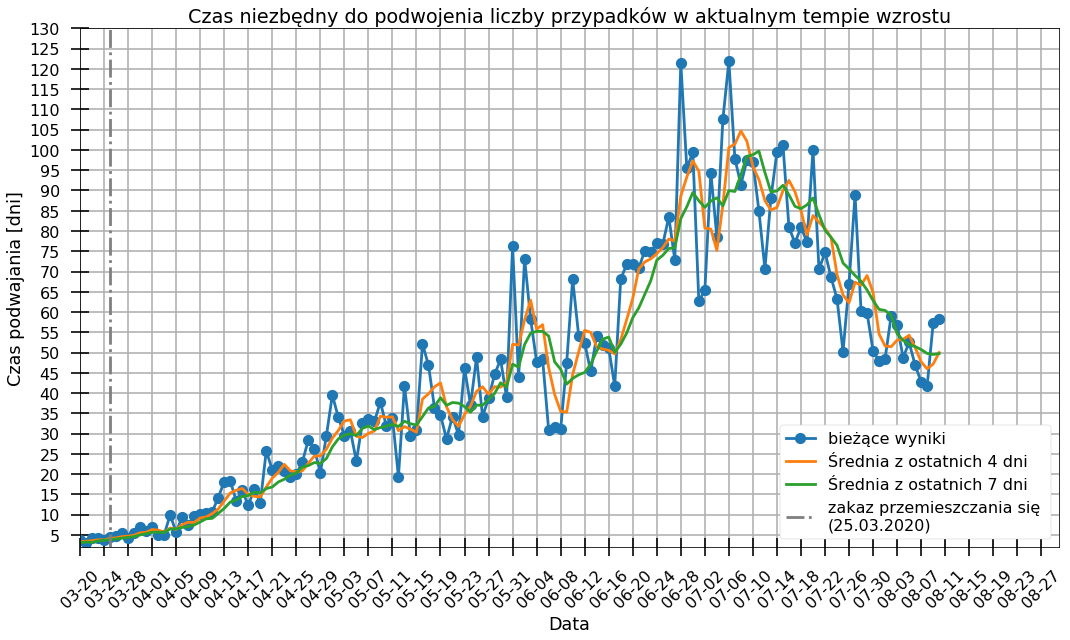

In [16]:
#data values difference and doubling time
doubling_time=[]
doubling_time_date=[]
for day, data_value, diff in zip(mdates.num2date(dates_num_extrapolate+dates_start), (pred_data*unnorm), 
                                 np.insert(np.diff(pred_data*unnorm),0,0)):
    #print(day, np.round(data_value), np.round(diff), np.log(2)/np.log(data_value/(data_value-diff)))
    doubling_time.append(np.log(2)/np.log(data_value/(data_value-diff)))
    doubling_time_date.append(day)

Ns=[4,7]
doubling_time_running_mean = []
for N in Ns:
    doubling_time_running_mean.append(pd.Series(doubling_time).rolling(window=N).mean().iloc[N-1:].values)

print("Last day")
print(day, np.round(data_value), np.round(diff), np.log(2)/np.log(data_value/(data_value-diff)))

print("last 7 days")
print(np.mean(doubling_time[-7:]))

fig, (ax) = plt.subplots(1, figsize=(15, 9), )
ax.plot(doubling_time_date, doubling_time, linestyle="-", marker="o", label="bieżące wyniki")
#ax.plot(doubling_time, linestyle="-", marker="o")

for N, mean in zip(Ns,doubling_time_running_mean):
    ax.plot(doubling_time_date[(N-1):], mean, label="Średnia z ostatnich "+str(N)+" dni")

ax.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='-.', color='gray', )    
    
tick_spacing=4
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_tick_params(rotation=45, direction="out")
ax.tick_params(direction='inout', length=18, colors='k')
y_tick_spacing=5
ax.yaxis.set_major_locator(ticker.MultipleLocator(y_tick_spacing))
ax.grid(True)
ax.set_xlim([datetime.date(2020, 3, 20), datetime.date(2020, 8, 30)])
ax.set_ylim([2,130])
ax.set(xlabel="Data",
       ylabel="Czas podwajania [dni]",
       title="Czas niezbędny do podwojenia liczby przypadków w aktualnym tempie wzrostu")
#ax.legend()
legend = ax.legend(frameon=1, facecolor='white', framealpha=1, fontsize=16, handlelength=1.8)#, loc='upper left')

plt.tight_layout()
plt.show()
fig.savefig("./predictions_for_poland_figures/czas_podwajania_"+timestamp+".png")


In [17]:
#subexponent prediction
for day, sub_exp_value in zip(mdates.num2date(subexp_dates_num_extrapolate+dates_start), (sub_exp_fit*unnorm)):
    if date.today() == day.date():
        print(day, sub_exp_value)

2020-08-10 00:00:00+00:00 49857.66568236718


In [18]:
#general logistic prediction
for day, gen_sig_value in zip(mdates.num2date(subexp_dates_num_extrapolate+dates_start), (gen_sig_fit*unnorm)):
    if date.today() == day.date():
        print(day, gen_sig_value)

2020-08-10 00:00:00+00:00 47887.23748107161


In [19]:
#linear prediction
for day, lin_value in zip(mdates.num2date(linear_dates_num_extrapolate[linear_start:]+dates_start), (linear_fit[linear_start:]*unnorm)):
    if date.today() <= day.date():
        print(day, lin_value)

2020-08-10 00:00:00+00:00 52259.50833327822
2020-08-11 00:00:00+00:00 52912.81904756452
2020-08-12 00:00:00+00:00 53566.129761850825
2020-08-13 00:00:00+00:00 54219.44047613714
2020-08-14 00:00:00+00:00 54872.75119042343
2020-08-15 00:00:00+00:00 55526.06190470974
2020-08-16 00:00:00+00:00 56179.37261899603
2020-08-17 00:00:00+00:00 56832.68333328234
2020-08-18 00:00:00+00:00 57485.99404756863
2020-08-19 00:00:00+00:00 58139.30476185494
2020-08-20 00:00:00+00:00 58792.61547614123
2020-08-21 00:00:00+00:00 59445.92619042754
2020-08-22 00:00:00+00:00 60099.23690471383
2020-08-23 00:00:00+00:00 60752.54761900014
2020-08-24 00:00:00+00:00 61405.85833328645
2020-08-25 00:00:00+00:00 62059.169047572745
2020-08-26 00:00:00+00:00 62712.47976185905
2020-08-27 00:00:00+00:00 63365.79047614534
2020-08-28 00:00:00+00:00 64019.101190431655
2020-08-29 00:00:00+00:00 64672.41190471794
2020-08-30 00:00:00+00:00 65325.72261900426
2020-08-31 00:00:00+00:00 65979.03333329054
2020-09-01 00:00:00+00:00 666